Epoch 1/30, Loss: 50.821557460687096
Epoch 2/30, Loss: 40.914247386475914
Epoch 3/30, Loss: 38.60639776327671
Epoch 4/30, Loss: 37.33686083606166
Epoch 5/30, Loss: 36.57622810102936
Epoch 6/30, Loss: 36.05075451451489
Epoch 7/30, Loss: 35.651598661373825
Epoch 8/30, Loss: 35.30035690160898
Epoch 9/30, Loss: 34.961554698455025
Epoch 10/30, Loss: 34.68394606745141
Epoch 11/30, Loss: 34.44631762789865
Epoch 12/30, Loss: 34.23099413488665
Epoch 13/30, Loss: 34.02392365789821
Epoch 14/30, Loss: 33.84104193173922
Epoch 15/30, Loss: 33.670985230013855
Epoch 16/30, Loss: 33.51317963233361
Epoch 17/30, Loss: 33.36602828849075
Epoch 18/30, Loss: 33.21964081332215
Epoch 19/30, Loss: 33.09349741079868
Epoch 20/30, Loss: 32.98308807764298
Epoch 21/30, Loss: 32.877369860298614
Epoch 22/30, Loss: 32.77901907048674
Epoch 23/30, Loss: 32.67431566450331
Epoch 24/30, Loss: 32.56927793453901
Epoch 25/30, Loss: 32.49110521414341
Epoch 26/30, Loss: 32.40709661826109
Epoch 27/30, Loss: 32.31619458728366
Epoc

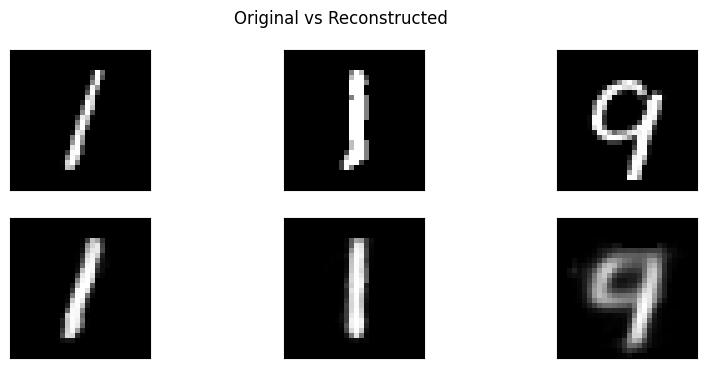

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, losses
from keras.datasets import mnist

# Load and prepare the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# VAE Architecture
latent_dim = 2  # Dimension of the latent space

# Encoder
encoder_inputs = layers.Input(shape=(784,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.)
    return z_mean + tf.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

# VAE model (combining encoder and decoder)
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, vae_outputs, name='vae')

@tf.function
def compute_vae_loss(encoder_inputs, vae_outputs, z_mean, z_log_var, kl_weight=0.00001):
    # Compute reconstruction loss
    reconstruction_loss = losses.mean_squared_error(encoder_inputs, vae_outputs)
    reconstruction_loss *= 784  # Rescale due to input shape

    # Compute KL divergence
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5

    # Compute total VAE loss
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_weight*kl_loss)
    return vae_loss

@tf.function
def train_step(encoder_inputs, vae_outputs, z_mean, z_log_var, optimizer):
    with tf.GradientTape() as tape:
        vae_outputs = decoder(encoder(encoder_inputs)[2])
        loss = compute_vae_loss(encoder_inputs, vae_outputs, z_mean, z_log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Training parameters
epochs = 30
batch_size = 128
optimizer = tf.keras.optimizers.Adam()

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for batch_data, _ in dataset:
        z_mean, z_log_var, encoded_images = encoder(batch_data, training=True)
        vae_outputs = decoder(encoded_images, training=True)
        loss = train_step(batch_data, vae_outputs, z_mean, z_log_var, optimizer)
        epoch_loss += loss.numpy()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (len(x_train) // batch_size)}')

# Test and Visualization
n_to_visualize = 3
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n_to_visualize))  # Two rows for original and reconstructed

# Choose specific test images
test_image_indices = [2, 14, 16]
images = x_test[test_image_indices]

# Generate reconstructions
_, _, encoded_images = encoder.predict(images)
decoded_images = decoder.predict(encoded_images)

for i, idx in enumerate(test_image_indices):
    # Original image
    figure[0:digit_size, i * digit_size:(i + 1) * digit_size] = images[i].reshape(28, 28)

    # Reconstructed image
    figure[digit_size:, i * digit_size:(i + 1) * digit_size] = decoded_images[i].reshape(28, 28)

plt.figure(figsize=(10, 4))  # Adjust figure size
plt.suptitle('Original vs Reconstructed')  # Add a title
for i in range(n_to_visualize):
    plt.subplot(2, n_to_visualize, i + 1)
    plt.imshow(figure[0:digit_size, i*digit_size :(i+1)*digit_size], cmap='gray')
    plt.xticks([])  # Remove ticks
    plt.yticks([])

    plt.subplot(2, n_to_visualize, n_to_visualize + i + 1)  # Subplot for reconstruction
    plt.imshow(figure[digit_size:, i*digit_size :(i+1)*digit_size], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show()